This is the main notebook where we will redistrict Iowa.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

# Prepping the census and geopandas dataframes

In [2]:
df=pd.read_csv('census.csv')
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,1,41.328528,-94.478164
1,1,Adams,3704,3,41.021656,-94.696906
2,2,Allamakee,14061,5,43.274964,-91.382751
3,3,Appanoose,12317,7,40.744683,-92.870345
4,4,Audubon,5674,9,41.679178,-94.904312


In [3]:
df['COUNTYFP10']=df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   county_id   99 non-null     int64  
 1   county      99 non-null     object 
 2   population  99 non-null     int64  
 3   COUNTYFP10  99 non-null     object 
 4   latitude    99 non-null     float64
 5   longitude   99 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ KB


In [5]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')
# shapefile_iowa.head()

### Fix alphabetization stuff now, not later!
shapefile_iowa=shapefile_iowa.sort_values('NAME10',ignore_index=True).copy()
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


# Merging pd and gpd dataframes and creating population heat map

## Prepping the data

In [6]:
map_population_by_county_data = shapefile_iowa.merge(df, on='COUNTYFP10')
county_populations = np.array(df['population'])
state_population = sum(county_populations)
df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


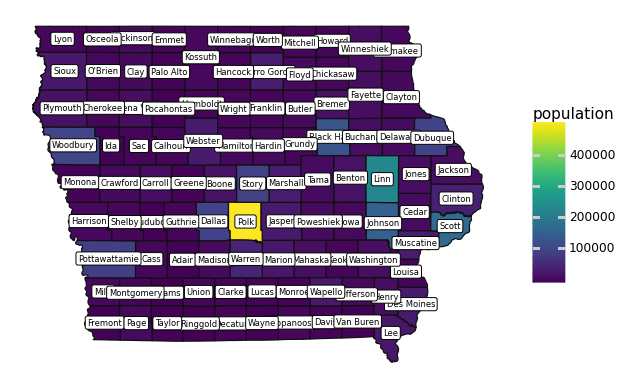

<ggplot: (8785319529825)>

In [7]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

## Population heat map for Iowa

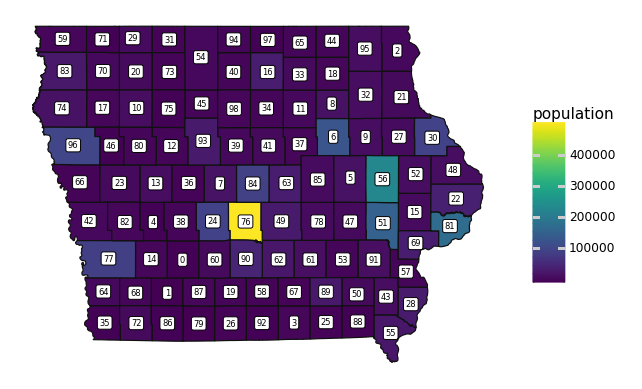

<ggplot: (8785316479922)>

In [8]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# SUBSET OF COUNTIES!


30, 48, 22, 81
27, 52, 15, 60
56, 51

In [9]:
shapefile_iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry'],
      dtype='object')

In [10]:
SpecialCols = ['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 
       'CD', 'geometry']

In [11]:
shapefile_iowa = shapefile_iowa[SpecialCols]

In [12]:
# just pick out 10 specified counties (in "nose")
shapefile_subState = shapefile_iowa.iloc[[30, 48, 22, 81, 27, 52, 15, 69,56, 51]].copy()

#order dataframe by index
shapefile_subState = shapefile_subState.sort_index().copy()

In [13]:
# mapPop_subState_data = shapefile_subState.merge(df, on='COUNTYFP10')
shapefile_subState = shapefile_subState.merge(df, on='COUNTYFP10')
county_pops_subState = np.array(shapefile_subState['population'])
subState_pop = sum(county_pops_subState)

In [14]:
county_pops_subState

array([ 18505,  46460,  17488,  99266,  19485, 152854,  20646, 230299,
        43235, 174669])

In [15]:
# shapefile_subState

In [16]:
shapefile_subState[['NAME10','county_id','population']]

,NAME10,county_id,population
0,Cedar,15,18505
1,Clinton,22,46460
2,Delaware,27,17488
3,Dubuque,30,99266
4,Jackson,48,19485
5,Johnson,51,152854
6,Jones,52,20646
7,Linn,56,230299
8,Muscatine,69,43235
9,Scott,81,174669


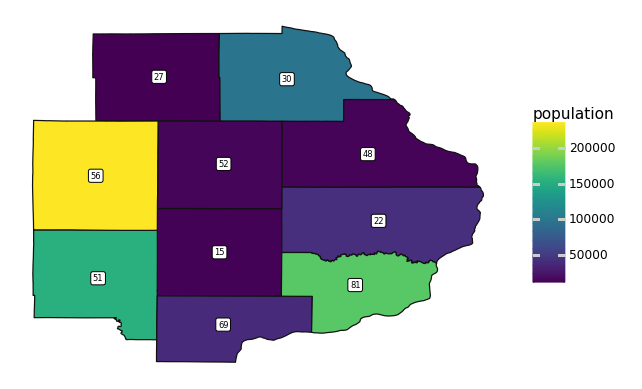

<ggplot: (8785316394051)>

In [17]:
mapPop_subState = (
    ggplot(shapefile_subState)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                    #  label='NAME10',size=2), 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
mapPop_subState

# Creating the adjacency matrix for Iowa counties

In [18]:
# ALREADY FIXED ABOVE!

# shapefile_alpha=shapefile_iowa.sort_values('NAME10',ignore_index=True).copy()

In [19]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

n_counties = shapefile_subState.shape[0]

subState_adjMat = pd.DataFrame()

for j in range(n_counties):
    subState_adjMat[j] = shapefile_subState.intersects(shapefile_subState.iloc[[j]].unary_union)
subState_adjMat = subState_adjMat - np.identity(n_counties)
subState_adjMat = subState_adjMat.astype(int)

subState_adjMat_bool = subState_adjMat.astype(bool)



In [20]:
subState_adjMat

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,1,1,1,1,1
1,1,0,0,0,1,0,1,0,0,1
2,0,0,0,1,0,0,1,1,0,0
3,0,0,1,0,1,0,1,0,0,0
4,0,1,0,1,0,0,1,0,0,0
5,1,0,0,0,0,0,0,1,1,0
6,1,1,1,1,1,0,0,1,0,0
7,1,0,1,0,0,1,1,0,0,0
8,1,0,0,0,0,1,0,0,0,1
9,1,1,0,0,0,0,0,0,1,0


# Optimization Model

## Creating decision variables, model, and objective function

In [21]:
# UNNECESSARY SINCE ALL MY COUNTIES HAVE 2 DIGITS ALREADY

# zp_county=np.array((df['county_id']).astype(str).str.pad(2,fillchar='0'))

In [22]:
zp_county = np.array(shapefile_subState['county_id']).astype(str)

In [23]:
zp_county

array(['15', '22', '27', '30', '48', '51', '52', '56', '69', '81'],
      dtype='<U21')

In [24]:
n_districts = 2

ideal_district_size=subState_pop/n_districts

# poperrorbound: usually we've been doing 1%. I did 5%, 10%
poperrorbound = .4

district_maximum=int(ideal_district_size*(1+poperrorbound))
district_minimum=int(ideal_district_size*(1-poperrorbound))

In [25]:
ideal_district_size

411453.5

In [26]:
# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [zp_county[i]+str(j) for j in range(n_districts)
                                for i in range(n_counties)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(n_counties,n_districts)

# # The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(n_counties,n_districts)

In [27]:
assignment

array([[Y_150, Y_151],
       [Y_220, Y_221],
       [Y_270, Y_271],
       [Y_300, Y_301],
       [Y_480, Y_481],
       [Y_510, Y_511],
       [Y_520, Y_521],
       [Y_560, Y_561],
       [Y_690, Y_691],
       [Y_810, Y_811]], dtype=object)

In [28]:
# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

## Initial Assignment / Allocation Constraints

In [29]:
# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_pops_subState[i] , "Allocate All " + str(i)

In [30]:
print(allocation[0][1], county_pops_subState[0])

X_151 18505


In [31]:
# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= county_pops_subState[i]*assignment[i][j] , "Allocation assignment of county" + str(i) + "to district" + str(j)
        model += allocation[i][j] >= .2*county_pops_subState[i]*assignment[i][j], "Minimum allocation of county" + str(i) + "to" + str(j)

In [32]:
#numpy documentation for np array
#https://numpy.org/doc/stable/glossary.html#term-row-major
# Contiguous districts constraints
for j in range(n_districts):
    for i in range(n_counties):
        model += 2*assignment[i][j] <= lpSum(assignment[:,j][subState_adjMat_bool[i]]), "Contiguity constraint for county " + str(i) +" in district " + str(j)

In [33]:
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= district_maximum , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= district_minimum , "District Size Minimum " + str(j)

In [34]:
# Only allow counties that meet certain critera to be split among multiple districts
# This not necessary for Iowa.
for i in range(n_counties): 
    if county_pops_subState[i] <= 75000: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment for county " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments for county " + str(i)

In [35]:
model

Supply-Demand-Problem:
MINIMIZE
1*Y_150 + 1*Y_151 + 1*Y_220 + 1*Y_221 + 1*Y_270 + 1*Y_271 + 1*Y_300 + 1*Y_301 + 1*Y_480 + 1*Y_481 + 1*Y_510 + 1*Y_511 + 1*Y_520 + 1*Y_521 + 1*Y_560 + 1*Y_561 + 1*Y_690 + 1*Y_691 + 1*Y_810 + 1*Y_811 + 0
SUBJECT TO
Allocate_All_0: X_150 + X_151 = 18505

Allocate_All_1: X_220 + X_221 = 46460

Allocate_All_2: X_270 + X_271 = 17488

Allocate_All_3: X_300 + X_301 = 99266

Allocate_All_4: X_480 + X_481 = 19485

Allocate_All_5: X_510 + X_511 = 152854

Allocate_All_6: X_520 + X_521 = 20646

Allocate_All_7: X_560 + X_561 = 230299

Allocate_All_8: X_690 + X_691 = 43235

Allocate_All_9: X_810 + X_811 = 174669

Allocation_assignment_of_county0to_district0: X_150 - 18505 Y_150 <= 0

Minimum_allocation_of_county0to0: X_150 - 3701 Y_150 >= 0

Allocation_assignment_of_county0to_district1: X_151 - 18505 Y_151 <= 0

Minimum_allocation_of_county0to1: X_151 - 3701 Y_151 >= 0

Allocation_assignment_of_county1to_district0: X_220 - 46460 Y_220 <= 0

Minimum_allocation_of_county

In [36]:
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /tmp/20919ad9cc0a436fba2e007c554eb947-pulp.lp -o /tmp/20919ad9cc0a436fba2e007c554eb947-pulp.sol
 --mipgap 0.05 --gomory
Reading problem data from '/tmp/20919ad9cc0a436fba2e007c554eb947-pulp.lp'...
84 rows, 40 columns, 256 non-zeros
40 integer variables, 20 of which are binary
178 lines were read
GLPK Integer Optimizer 5.0
84 rows, 40 columns, 256 non-zeros
40 integer variables, 20 of which are binary
Preprocessing...
80 rows, 40 columns, 248 non-zeros
40 integer variables, 20 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.303e+05  ratio =  2.303e+05
GM: min|aij| =  5.213e-01  max|aij| =  1.918e+00  ratio =  3.680e+00
EQ: min|aij| =  2.780e-01  max|aij| =  1.000e+00  ratio =  3.598e+00
2N: min|aij| =  2.135e-01  max|aij| =  1.333e+00  ratio =  6.242e+00
Constructing initial basis...
Size of triangular part is 80
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
80 rows, 40 colu

In [37]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 0:  18505
County 1 assigned to district 1:  46460
County 2 assigned to district 1:  17488
County 3 assigned to district 1:  99266
County 4 assigned to district 1:  19485
County 5 assigned to district 0:  152854
County 6 assigned to district 1:  20646
County 7 assigned to district 1:  230299
County 8 assigned to district 0:  43235
County 9 assigned to district 0:  174669


# Visualizing the districts

## Prepping the data for visualization

In [38]:
#turn index within the subset to main ID
shapefile_subState.iloc[1]['county_id']

22

In [39]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            # 'County': i,
            'county_id': shapefile_subState.iloc[i]['county_id'],  #see above
            'District': j+1,
            'Dist_Assignment': int(assignment[i][j].value()*(j+1)),
            'Dist_Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['Dist_Assignment'] != 0]
results = results.sort_values(['county_id', 'District'])


In [40]:
results

,county_id,District,Dist_Assignment,Dist_Allocation
0,15,1,1,18505
3,22,2,2,46460
5,27,2,2,17488
7,30,2,2,99266
9,48,2,2,19485
10,51,1,1,152854
13,52,2,2,20646
15,56,2,2,230299
16,69,1,1,43235
18,81,1,1,174669


In [41]:
new_districts_shapefile = shapefile_subState.merge(results, left_on='county_id',right_on='county_id',suffixes = ('_ID','_Name'))

In [42]:
new_districts_shapefile.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,CD,geometry,county_id,county,population,latitude,longitude,District,Dist_Assignment,Dist_Allocation
0,19,031,19031,Cedar,Cedar County,1500731293,6385840,+41.7723547,-091.1321900,18499,2,"POLYGON ((-91.09434 41.59747, -91.09481 41.597...",15,Cedar,18505,41.772355,-91.132190,1,1,18505
1,19,045,19045,Clinton,Clinton County,1799821282,39523759,+41.8980732,-090.5342431,49116,2,"POLYGON ((-90.67005 41.76363, -90.67007 41.763...",22,Clinton,46460,41.898073,-90.534243,2,2,46460
2,19,055,19055,Delaware,Delaware County,1496381153,3082496,+42.4730031,-091.3594425,17764,1,"POLYGON ((-91.59740 42.46924, -91.59740 42.469...",27,Delaware,17488,42.473003,-91.359443,2,2,17488
3,19,061,19061,Dubuque,Dubuque County,1575501687,21569071,+42.4634808,-090.8787708,93653,1,"POLYGON ((-91.13089 42.47126, -91.13115 42.471...",30,Dubuque,99266,42.463481,-90.878771,2,2,99266
4,19,097,19097,Jackson,Jackson County,1647332960,35141529,+42.1642812,-090.5745965,19848,1,"POLYGON ((-90.89823 42.12059, -90.89837 42.125...",48,Jackson,19485,42.164281,-90.574596,2,2,19485


In [43]:
# results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
# results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results)):
#     if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
#         results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
#                                                         str(results['Multiple_District'].loc[i]))
# results = results.sort_values(['District','County_Name'])
# results.index = results['County_ID']

## Creating the maps

In [44]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Dist_Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Dist_Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [45]:
new_districts_shapefile['Dist_Assignment'] = new_districts_shapefile['Dist_Assignment'].astype("category")

In [46]:
# new_districts_shapefile.loc[new_districts_shapefile['Dist_Assignment']==2]

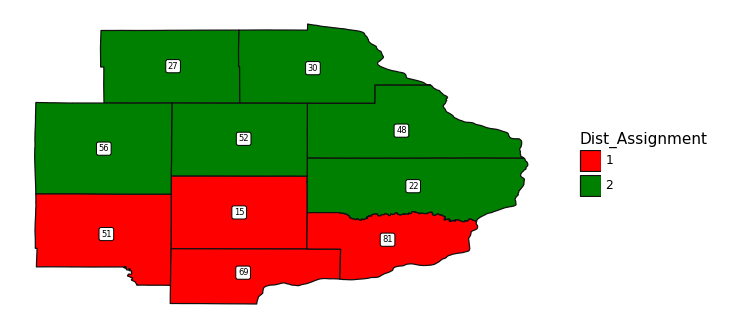

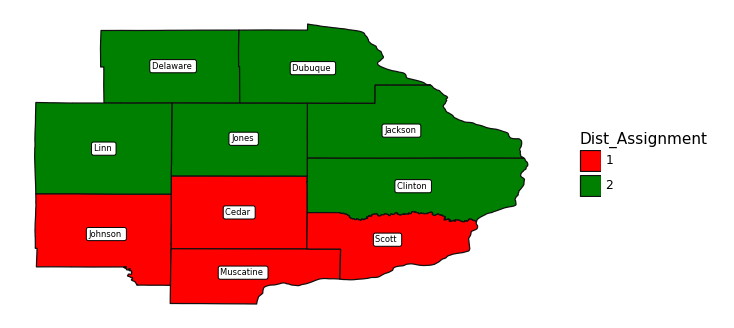

(<ggplot: (8785323699595)>, <ggplot: (8785315772474)>)

In [47]:
iowa_map(new_districts_shapefile)

In [48]:
district_totals = pd.DataFrame(results.groupby('District')['Dist_Allocation'].sum().astype('int64'))
district_totals

,Dist_Allocation
District,
1,389263
2,433644


# NOW! calc border?

## First, reproject to UTM 15N

https://epsg.io/26915-1709

In [49]:
shapefile_subState.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [50]:
shapefile_subState_projected = shapefile_subState.to_crs(epsg=26915)
shapefile_subState_projected.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 96°W to 90°W and NAD83 by country
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [51]:
new_districts_shapefile_projected = new_districts_shapefile.to_crs(epsg=26915)
new_districts_shapefile_projected.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 96°W to 90°W and NAD83 by country
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

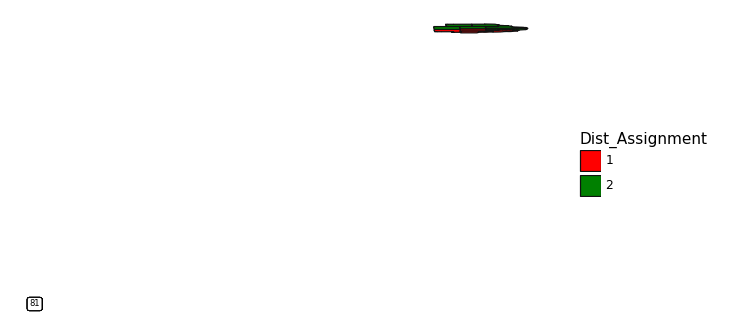

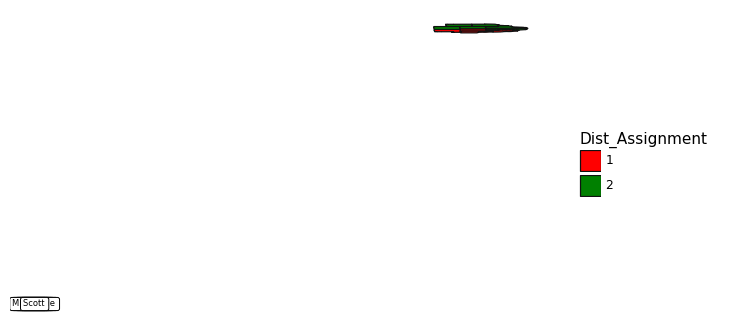

(<ggplot: (8785316362009)>, <ggplot: (8785315701167)>)

In [52]:
iowa_map(new_districts_shapefile_projected)

## now calculate boundaries?

In [53]:
shapefile_subState['geometry'].area

/tmp/ipykernel_27060/3818848921.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



0    0.163199
1    0.199560
2    0.164144
3    0.174823
4    0.183316
5    0.174498
6    0.162700
7    0.204158
8    0.125408
9    0.131042
dtype: float64

In [54]:
shapefile_subState_projected['geometry'].area

0    1.506810e+09
1    1.839785e+09
2    1.498933e+09
3    1.596990e+09
4    1.682801e+09
5    1.613214e+09
6    1.494120e+09
7    1.875584e+09
8    1.163025e+09
9    1.212864e+09
dtype: float64

In [55]:
gdf_subState_testing = new_districts_shapefile_projected
gdf_subState_testing["area"] = gdf_subState_testing["geometry"].area
gdf_subState_testing["perimeter"] = gdf_subState_testing["geometry"].length

In [56]:
gdf_subState_testing.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,county_id,county,population,latitude,longitude,District,Dist_Assignment,Dist_Allocation,area,perimeter
0,19,031,19031,Cedar,Cedar County,1500731293,6385840,+41.7723547,-091.1321900,18499,...,15,Cedar,18505,41.772355,-91.132190,1,1,18505,1.506810e+09,155333.700386
1,19,045,19045,Clinton,Clinton County,1799821282,39523759,+41.8980732,-090.5342431,49116,...,22,Clinton,46460,41.898073,-90.534243,2,2,46460,1.839785e+09,206497.099838
2,19,055,19055,Delaware,Delaware County,1496381153,3082496,+42.4730031,-091.3594425,17764,...,27,Delaware,17488,42.473003,-91.359443,2,2,17488,1.498933e+09,156110.824557
3,19,061,19061,Dubuque,Dubuque County,1575501687,21569071,+42.4634808,-090.8787708,93653,...,30,Dubuque,99266,42.463481,-90.878771,2,2,99266,1.596990e+09,180675.300927
4,19,097,19097,Jackson,Jackson County,1647332960,35141529,+42.1642812,-090.5745965,19848,...,48,Jackson,19485,42.164281,-90.574596,2,2,19485,1.682801e+09,189411.988084


In [57]:
gdf_subState_testing.iloc[0]

STATEFP10                                                         19
COUNTYFP10                                                       031
GEOID10                                                        19031
NAME10                                                         Cedar
NAMELSAD10                                              Cedar County
ALAND10                                                   1500731293
AWATER10                                                     6385840
INTPTLAT10                                               +41.7723547
INTPTLON10                                              -091.1321900
TOTPOP                                                         18499
CD                                                                 2
geometry           POLYGON ((658816.8950950331 4606839.017172024,...
county_id                                                         15
county                                                        Cedar 
population                        

according to wikipedia/census:
Cedar county area: 582 square miles (1510 square kilometers), 579 (1500) land vs 2.5 (6.5) water

In [58]:
gdf_subState_testing.iloc[0]["ALAND10"]+ gdf_subState_testing.iloc[0]["AWATER10"]

1507117133

In [59]:
# convert square meters to square kilometers
1507117133 / (1000*1000)

1507.117133

In [60]:
1506809883.31238 / (1000*1000)

1506.8098833123802

https://stackoverflow.com/questions/55012862/return-length-of-border-segment-between-geographic-areas-in-geopandas

In [61]:
Cedar = gdf_subState_testing.geometry[0]
Clinton = gdf_subState_testing.geometry[1]

In [62]:
cedar_intersect_clinton = Cedar.intersection(Clinton)

In [63]:
cedar_clint_length = cedar_intersect_clinton.length
print("Length in meters: %d" % cedar_clint_length)

Length in meters: 19521


## make an adjacency/shared perimeter matrix for all 10 counties

In [64]:
n_counties

10

In [65]:
foo = np.zeros((n_counties,n_counties))

In [66]:
foo[1,2] = 7
foo

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 7., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [83]:
# sharedperim_matrix = pd.DataFrame()
sharedperim_matrix = np.zeros((n_counties,n_counties))

for j in range(n_counties):
    county_j = gdf_subState_testing.geometry[j]
    for i in range(n_counties):
        if j != i :
            county_i = gdf_subState_testing.geometry[i]
            intersection_length = county_j.intersection(county_i)
            sharedperim_matrix[i,j] = intersection_length.length
        else:
            sharedperim_matrix[i,j]=0

sharedperim_matrix

array([[    0.        , 19521.18003827,     0.        ,     0.        ,
            0.        , 29091.28981443, 38752.38125981,  9699.73978714,
        38914.06495524, 19355.04453139],
       [19521.18003827,     0.        ,     0.        ,     0.        ,
        61650.3242549 ,     0.        ,  9700.51177533,     0.        ,
            0.        , 74093.82316843],
       [    0.        ,     0.        ,     0.        , 39165.1100384 ,
            0.        ,     0.        , 19251.93048184, 19272.40114282,
            0.        ,     0.        ],
       [    0.        ,     0.        , 39165.1100384 ,     0.        ,
        44675.5047543 ,     0.        , 19148.8573389 ,     0.        ,
            0.        ,     0.        ],
       [    0.        , 61650.3242549 ,     0.        , 44675.5047543 ,
            0.        ,     0.        , 29069.44870252,     0.        ,
            0.        ,     0.        ],
       [29091.28981443,     0.        ,     0.        ,     0.        ,
   

In [84]:
# summing INTERNAL perimeters
sharedperim_matrix = sharedperim_matrix.astype(int)
np.sum(sharedperim_matrix,axis=0)

array([155332, 164964,  77688, 102988, 135394,  87187, 154700, 106391,
        84019, 119097])

In [82]:
gdf_subState_testing["perimeter"]
# this should be different for all counties on the boundary
# of the subset (i.e. all except cedar/jones,
#  which are 0 (15) and 6 (52))

0    155333.700386
1    206497.099838
2    156110.824557
3    180675.300927
4    189411.988084
5    178029.457820
6    154703.686478
7    174299.455538
8    151668.299341
9    178982.512569
Name: perimeter, dtype: float64